In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score, precision_score, recall_score
from functools import partial
import itertools

from tools.preprocess import load_datasets, preprocess_mushrooms_datasets
from tools.distance import ManhattanDistance, EuclideanDistance
from tools.voting import (
    MajorityClassVote,
    InverseDistanceWeightedVote,
    ShepardsWorkVote,
)
from tools.knn import KNNClassifier
from tools.metrics import cross_validate

import logging

logging.basicConfig(level=logging.ERROR, format="%(levelname)s - %(message)s")
logger = logging.getLogger()

In [2]:
train_dfs = load_datasets("../data/raw/mushroom/mushroom.fold.*.train.arff")
test_dfs = load_datasets("../data/raw/mushroom/mushroom.fold.*.test.arff")

print(f"\nNumber of training dataframes: {len(train_dfs)}")
print(f"Number of test dataframes: {len(test_dfs)}")
print()
train_dfs[0].head()


Number of training dataframes: 10
Number of test dataframes: 10



,cap-shape,cap-surface,cap-color,bruises?,odor,gill-attachment,gill-spacing,gill-size,gill-color,stalk-shape,...,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat,class
0,b'f',b'y',b'y',b'f',b'f',b'f',b'c',b'b',b'h',b'e',...,b'b',b'p',b'p',b'w',b'o',b'l',b'h',b'v',b'g',b'p'
1,b'f',b's',b'b',b't',b'f',b'f',b'c',b'b',b'p',b't',...,b'w',b'w',b'p',b'w',b'o',b'p',b'h',b's',b'g',b'p'
2,b'x',b'y',b'g',b't',b'n',b'f',b'c',b'b',b'w',b'e',...,b'w',b'w',b'p',b'w',b't',b'p',b'w',b'y',b'p',b'e'
3,b'x',b'y',b'e',b't',b'n',b'f',b'c',b'b',b'n',b't',...,b'g',b'g',b'p',b'w',b'o',b'p',b'k',b'y',b'd',b'e'
4,b'x',b's',b'g',b'f',b'c',b'f',b'w',b'n',b'p',b'e',...,b'w',b'w',b'p',b'w',b'o',b'p',b'k',b's',b'd',b'p'


In [3]:
train_dfs = list(map(preprocess_mushrooms_datasets, train_dfs))
test_dfs = list(map(preprocess_mushrooms_datasets, test_dfs))

train_dfs[0].head()

,cap-shape,cap-surface,cap-color,bruises?,odor,gill-attachment,gill-spacing,gill-size,gill-color,stalk-shape,...,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat,class
0,2,3,9,0,2,1,0,0,3,0,...,0,6,0,2,1,2,1,4,1,1
1,2,2,0,1,2,1,0,0,7,1,...,7,7,0,2,1,4,1,3,1,1
2,5,3,3,1,5,1,0,0,10,0,...,7,7,0,2,2,4,7,5,4,0
3,5,3,2,1,5,1,0,0,5,1,...,3,3,0,2,1,4,2,5,0,0
4,5,2,3,0,1,1,1,1,7,0,...,7,7,0,2,1,4,2,3,0,1


In [4]:
k_values = [1, 3, 5, 7]
distance_funcs = [ManhattanDistance(), EuclideanDistance()]
voting_funcs = [MajorityClassVote(), InverseDistanceWeightedVote(), ShepardsWorkVote()]

results = pd.DataFrame(
    columns=[
        "k",
        "distance_func",
        "voting_func",
        "f1_mean",
        "f1_std",
    ]
)
for k, distance_func, voting_func in itertools.product(
    k_values, distance_funcs, voting_funcs
):
    knn = KNNClassifier(
        k=k,
        distance_func=distance_func,
        voting_func=voting_func,
        weights=np.ones(len(train_dfs[0].columns) - 1),
    )
    scores = cross_validate(
        knn,
        train_dfs,
        test_dfs,
        target_col="class",
        score_func=partial(f1_score, average="weighted"),
    )
    results.loc[len(results)] = [
        k,
        distance_func.__class__.__name__,
        voting_func.__class__.__name__,
        scores.mean(),
        scores.std(),
    ]

results.sort_values(by="f1_mean", ascending=False)

/Users/zachparent/src/MAI/iml/work2/tools/voting.py:41: RuntimeWarning: divide by zero encountered in scalar divide
  inverse_distances = [1 / (d**self.distance_weight) for d in distances]
/Users/zachparent/src/MAI/iml/work2/tools/voting.py:41: RuntimeWarning: divide by zero encountered in scalar divide
  inverse_distances = [1 / (d**self.distance_weight) for d in distances]
/Users/zachparent/src/MAI/iml/work2/tools/voting.py:41: RuntimeWarning: divide by zero encountered in scalar divide
  inverse_distances = [1 / (d**self.distance_weight) for d in distances]
/Users/zachparent/src/MAI/iml/work2/tools/voting.py:41: RuntimeWarning: divide by zero encountered in scalar divide
  inverse_distances = [1 / (d**self.distance_weight) for d in distances]
/Users/zachparent/src/MAI/iml/work2/tools/voting.py:41: RuntimeWarning: divide by zero encountered in scalar divide
  inverse_distances = [1 / (d**self.distance_weight) for d in distances]
/Users/zachparent/src/MAI/iml/work2/tools/voting.py:41:

,k,distance_func,voting_func,f1_mean,f1_std
0,1,ManhattanDistance,MajorityClassVote,0.950975,0.028101
2,1,ManhattanDistance,ShepardsWorkVote,0.950975,0.028101
1,1,ManhattanDistance,InverseDistanceWeightedVote,0.950975,0.028101
6,3,ManhattanDistance,MajorityClassVote,0.932009,0.027540
12,5,ManhattanDistance,MajorityClassVote,0.930954,0.025223
18,7,ManhattanDistance,MajorityClassVote,0.923936,0.018772
5,1,EuclideanDistance,ShepardsWorkVote,0.903883,0.036985
3,1,EuclideanDistance,MajorityClassVote,0.903883,0.036985
4,1,EuclideanDistance,InverseDistanceWeightedVote,0.903883,0.036985
7,3,ManhattanDistance,InverseDistanceWeightedVote,0.897979,0.032763


In [5]:
knn = KNNClassifier(
    k=1,
    distance_func=ManhattanDistance(),
    voting_func=MajorityClassVote(),
    weights=np.ones(len(train_dfs[0].columns) - 1),
)
scores = pd.DataFrame(
    columns=["precision", "recall", "f1"],
    data=cross_validate(
        knn,
        train_dfs,
        test_dfs,
        target_col="class",
        score_func=lambda actuals, preds: (
            precision_score(actuals, preds, average="weighted"),
            recall_score(actuals, preds, average="weighted"),
            f1_score(actuals, preds, average="weighted"),
        ),
    ),
)
scores

,precision,recall,f1
0,0.950347,0.95,0.950077
1,0.960500,0.96,0.959851
2,0.940000,0.94,0.940000
3,0.970250,0.97,0.970027
4,0.930116,0.93,0.929965
5,0.900562,0.90,0.899920
6,1.000000,1.00,1.000000
7,0.980690,0.98,0.979943
8,0.960000,0.96,0.960000
9,0.920673,0.92,0.919968


# Pre-Analysis

In [6]:
preds = []
actuals = []

for train_df, test_df in zip(train_dfs, test_dfs):
    decision_tree = DecisionTreeClassifier()
    decision_tree.fit(train_df.drop("class", axis=1), train_df["class"])
    preds.extend(decision_tree.predict(test_df.drop("class", axis=1)))
    actuals.extend(test_df["class"])

print(classification_report(actuals, preds))

              precision    recall  f1-score   support

           0       0.93      0.94      0.93       494
           1       0.94      0.93      0.93       506

    accuracy                           0.93      1000
   macro avg       0.93      0.93      0.93      1000
weighted avg       0.93      0.93      0.93      1000



In [7]:
feature_importances = pd.DataFrame(
    {
        "feature": train_dfs[0].drop("class", axis=1).columns,
        "importance": decision_tree.feature_importances_,
        "index": range(len(decision_tree.feature_importances_)),
    }
)
top_5_features = feature_importances.sort_values("importance", ascending=False).head(5)
print("Top 5 features:")
top_5_features

Top 5 features:


,feature,importance,index
8,gill-color,0.372931,8
4,odor,0.306495,4
10,stalk-root,0.135556,10
7,gill-size,0.077070,7
19,spore-print-color,0.039063,19


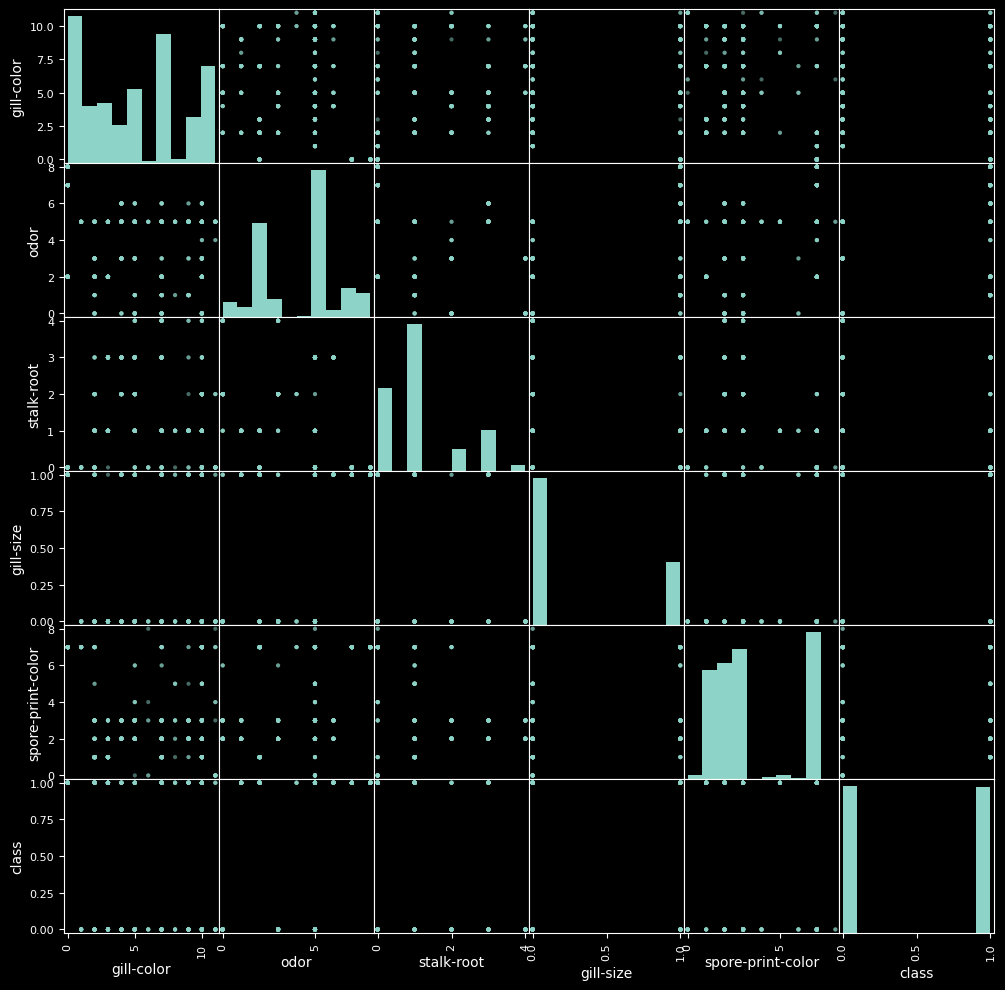

In [8]:
pd.plotting.scatter_matrix(
    pd.concat(train_dfs + test_dfs)[top_5_features.feature.values.tolist() + ["class"]],
    figsize=(12, 12),
)
plt.show()

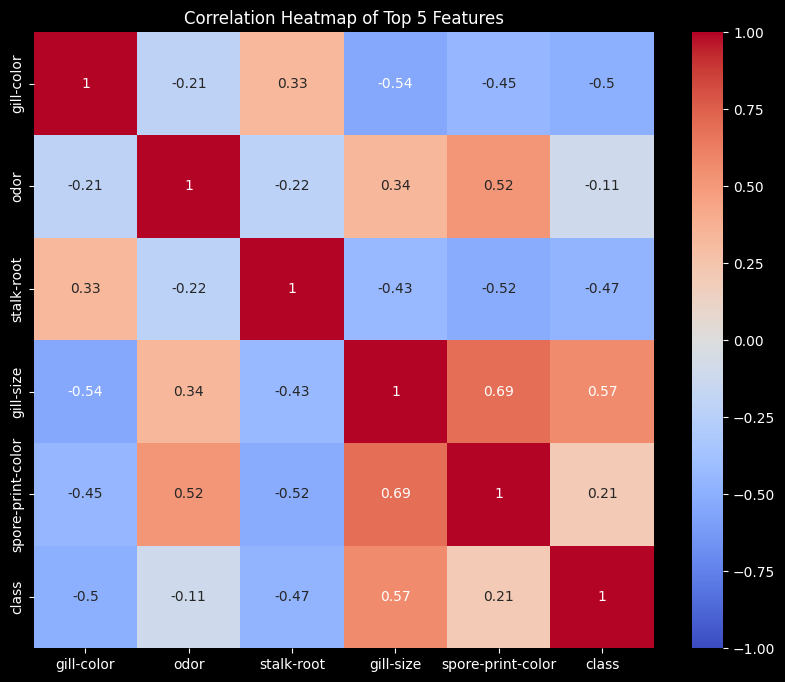

In [9]:
import seaborn as sns

top_5_features_and_class = top_5_features["feature"].tolist() + ["class"]
corr_matrix = pd.concat(train_dfs + test_dfs)[top_5_features_and_class].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", vmin=-1, vmax=1, center=0)
plt.title("Correlation Heatmap of Top 5 Features")
plt.show()